In [1]:
import os
from statistics import mean
from collections import defaultdict

import polars as pl
import matplotlib.pyplot as plt

from dltf.utils.metrics import recall_at_k, ndcg_at_k

In [2]:
analyses_dir = f'{os.path.abspath(os.path.curdir)}/results/demo_mate'
analyses_dir

'/home/nanni/unimore/datalake-table-finder/multi_key_join/results/demo_mate'

# Analyses

## How many results are returned by BSL and MC? And how many results of BSL are included by those from MC? 

In [3]:
multi_keys = [
    'country',
    'location-name'
]

T = 0.0
N = 100
K = 10

min_h_t = [0.0, 0.4]
k_values = [1, 5, 10]

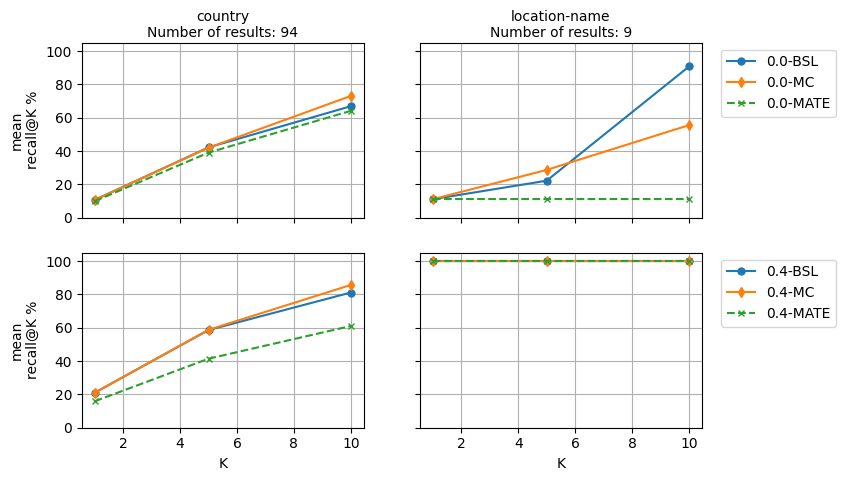

In [4]:
versions = ['BSL', 'MC', 'MATE']

line_color = {
    'BSL': {
        'line': '-o',
        'color': 'tab:blue'
    },
    'MC': {
        'line': '-d', 
        'color': 'tab:orange'
    },
    'MATE': {
        'line': '--x', 
        'color': 'tab:green'
    }
}

data = defaultdict(dict)
fig, all_axs_rec = plt.subplots(len(min_h_t), len(multi_keys), sharey='row', sharex='col', figsize=(4 * len(multi_keys), 5))
plt.subplots_adjust(hspace=0.2)

for i, (min_h, axs_rec) in enumerate(zip(min_h_t, all_axs_rec)):
    for multi_key, axrec in zip(multi_keys, axs_rec):
        
        # Load the CSV file
        results = (
                pl
                .read_csv(f'{analyses_dir}/{multi_key}/N{N}_K{K}/final_results.csv')
                .filter(pl.col('version').is_in(versions))
                .with_columns(
                    (pl.col(f'overlap_{min_h}') > 0).cast(pl.Int8).alias(f'overlap_{min_h}_01'),
                    pl.col(f'overlap_{min_h}').replace(-2, 0)
                )
            )
        
        # take only those queries that have at least one accepted candidate
        analyses_results = [
            q for (q, ), group in results.group_by('query_id') 
            if any(group.select(f'overlap_{min_h}').filter(pl.col(f'overlap_{min_h}') > 0).rows())]

        results = results.filter(pl.col('query_id').is_in(analyses_results))
        
        # compute the cumulative number of total valid results for both BSL and MC
        # and the % of BSL results that is a subset of the MC results (--> this btw doens't tell much about
        # values that BSL only discovered) and compute the recall@K (0/1 values with meaning "not valid/valid candidate")
        num_results_per_k = []
        silver_standard = {'01': {}, 'relevance': {}}

        for version in versions:
            data[version]['final_recall']           = {}
            data[version]['final_ndcg']             = {}
            data[version]['final_mean_nres']        = {}
            data[version]['results_for_query']      = {}
            data[version]['results_for_query_01']   = {}
            data[version]['results']                = results.filter((pl.col('version') == version))

        query_groups = results.group_by('query_id')

        # compute the silver standard, both as 0/1 values (not-valid/valid)
        # and relevance values (the overlap between the query columns and the result table)
        for (q, ), qgroup in query_groups:
            silver_standard['relevance'][q], silver_standard['01'][q] = zip(
                *results
                .filter(pl.col('query_id') == q)
                .unique(subset=['query_id', 'result_id'])
                .select([f'overlap_{min_h}', f'overlap_{min_h}_01'])
                .sort(by=f'overlap_{min_h}', descending=True)
                .rows())
        
        # for each version and query extract as a list the results, both as 0/1 values and relevance values
        for (version, q), qgroup in results.group_by('version', 'query_id'):
            data[version]['results_for_query_01'][q] = qgroup.select(f'overlap_{min_h}_01').to_series().to_list()
            data[version]['results_for_query'][q] = qgroup.select(f'overlap_{min_h}').to_series().to_list()
        
        # for each K, compute recall@K, nDCG@K 
        # and the mean number of results found per query
        for k in k_values:
            for version in versions:
                data[version]['recall']     = []
                data[version]['ndcg']       = []
                data[version]['mean_nres']  = []

            for (q, ), qgroup in query_groups:
                for version in versions:
                    r = data[version]['results_for_query_01'][q] if q in data[version]['results_for_query_01'] else []
                    data[version]['mean_nres'].append(sum(r[:k]))
                    data[version]['recall'].append(recall_at_k(silver_standard['01'][q], r, k))
                    
                    r = data[version]['results_for_query'][q] if q in data[version]['results_for_query'] else []
                    data[version]['ndcg'].append(ndcg_at_k(list(silver_standard['relevance'][q]), list(r), k))

            for version in versions:
                data[version]['final_recall'][k]    = 100 * mean(data[version]['recall'])
                data[version]['final_ndcg'][k]      = 100 * mean(data[version]['ndcg'])
                data[version]['final_mean_nres'][k] = mean(data[version]['mean_nres'])

        for version in versions:
            axrec.plot(k_values, list(data[version]['final_recall'].values()),      line_color[version]['line'], label=f'{min_h}-{version}', markersize=5)
        
        if i == 0:
            axrec.set_xlabel(f'{multi_key}\nNumber of results: {len(analyses_results)}')
            axrec.xaxis.set_label_position('top')
        elif i == len(min_h_t) - 1:
            axrec.set_xlabel(f"K")
        
        axrec.grid(True)

    axs_rec[0].set_ylabel('mean\nrecall@K %')
    axs_rec[0].set_ylim(0, 105)

    axs_rec[-1].legend(loc='best',      bbox_to_anchor=(0., 0., 1.5, 1))